In [1]:
import findspark
findspark.init()

# Create a spark-session (akin to what pyspark provides when it is started)
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

In [2]:
# Access the Spark Context and config of our Spark application (--spark.driver.memory 4G was passed in command line)
sc = spark.sparkContext
sc.getConf().getAll()

[('spark.history.kerberos.keytab', 'none'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.app.id', 'application_1596476144697_0003'),
 ('spark.driver.appUIAddress', 'http://slalomdsvm:4040'),
 ('spark.history.ui.port', '18081'),
 ('spark.driver.memory', '512M'),
 ('spark.driver.extraLibraryPath',
  '/usr/hdp/current/hadoop-client/lib/native:/usr/hdp/current/hadoop-client/lib/native/Linux-amd64-64'),
 ('spark.history.fs.cleaner.interval', '7d'),
 ('spark.shuffle.io.serverThreads', '128'),
 ('spark.yarn.historyServer.address', 'slalomdsvm:18081'),
 ('spark.sql.streaming.streamingQueryListeners', ''),
 ('spark.executor.extraLibraryPath',
  '/usr/hdp/current/hadoop-client/lib/native:/usr/hdp/current/hadoop-client/lib/native/Linux-amd64-64'),
 ('spark.sql.statistics.fallBackToHdfs', 'true'),
 ('spark.executorEnv.PYTHONPATH',
  '{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.7-src.zip'),
 ('spark.shuffle.file.buffer', '1m'),
 ('spark.history.provider',
  'org.apache.spark.deploy.history.FsHistory

In [3]:
from pyspark.sql.functions import avg, stddev, count, col, desc, year, month, dayofmonth, collect_list, collect_set, udf, explode
from pyspark.sql.types import ArrayType, StringType, IntegerType
import hashlib
from scipy.stats import norm
import pandas as pd
import datetime
import pylab as plt
from matplotlib.pyplot import figure
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## Load data

In [4]:
path = "/user/vagrant/data/earth-surface-temperature/csv/GlobalLandTemperaturesByMajorCity.csv"

In [5]:
df = spark \
.read \
.option("header", "true") \
.option("inferschema", "true") \
.option("mode", "DROPMALFORMED") \
.csv(path)

In [6]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[dt: timestamp, AverageTemperature: double, AverageTemperatureUncertainty: double, City: string, Country: string, Latitude: string, Longitude: string]>

In [7]:
df.show(5)

+-------------------+------------------+-----------------------------+-------+-------------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-------+-------------+--------+---------+
|1849-01-01 00:00:00|            26.704|                        1.435|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-02-01 00:00:00|            27.434|                        1.362|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-03-01 00:00:00|            28.101|                        1.612|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-04-01 00:00:00|             26.14|           1.3869999999999998|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-05-01 00:00:00|            25.427|                          1.2|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
+-------------------+------------------+-----------------------------+-------+-------------+--------+---

In [8]:
# Number of observations
df.count()

239177

In [9]:
# Number of unique cities
df.select('City').distinct().count()

100

## Add year month day columns

In [10]:
df1 = df \
.withColumn('year', year(df.dt)) \
.withColumn('month', month(df.dt)) \
.withColumn('day', dayofmonth(df.dt))

In [11]:
df1.printSchema

<bound method DataFrame.printSchema of DataFrame[dt: timestamp, AverageTemperature: double, AverageTemperatureUncertainty: double, City: string, Country: string, Latitude: string, Longitude: string, year: int, month: int, day: int]>

In [12]:
df1.limit(10).toPandas().head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,day
0,1849-01-01 00:14:02,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,1,1
1,1849-02-01 00:14:02,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,2,1
2,1849-03-01 00:14:02,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,3,1
3,1849-04-01 00:14:02,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,4,1
4,1849-05-01 00:14:02,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849,5,1


## Ensure measurements are always made in the same set of cities

In [13]:
# The best list of cities is the list with the highest number of observations (the most dates)
# Not all cities have the same number of observations
# -> different dates will have observations coming from different cities

df1 \
.groupBy('City') \
.agg(count('*').alias('n_obs')) \
.orderBy('n_obs') \
.toPandas()

,City,n_obs
0,Lima,1591
1,Umm Durman,1857
2,Durban,1881
3,Cape Town,1881
4,Luanda,1893
...,...,...
95,Toronto,3239
96,Rome,3239
97,Saint Petersburg,3239
98,Kiev,3239


In [14]:
# For each year-month:
# Get the list of cities where temperature was measured at least once 
# (and some stats)

udf_sort = udf(lambda x: sorted(list(x)), ArrayType(StringType()))
udf_hash = udf(lambda x: hashlib.md5(''.join(x).encode()).hexdigest(), StringType())
udf_len = udf(lambda x: len(x), IntegerType())

df2 = df1 \
.groupBy('year', 'month') \
.agg(collect_set('City').alias('cities')) \
.withColumn('cities_list', udf_sort('cities')) \
.withColumn('n_cities', udf_len('cities_list')) \
.withColumn('cities_list_hash', udf_hash('cities_list')) \
.select('year', 'month', 'cities_list', 'n_cities', 'cities_list_hash')

df2.toPandas()

,year,month,cities_list,n_cities,cities_list_hash
0,1769,8,"[Ankara, Berlin, Casablanca, Chicago, Istanbul...",16,dcdcecfad72c53baf6057bf77f692253
1,1772,8,"[Ankara, Berlin, Casablanca, Chicago, Istanbul...",16,dcdcecfad72c53baf6057bf77f692253
2,1796,10,"[Ahmadabad, Aleppo, Alexandria, Ankara, Bangal...",35,95ca58190ebc109420f21f5d0fe87a1f
3,1859,3,"[Abidjan, Addis Abeba, Ahmadabad, Aleppo, Alex...",99,a79fb4bbdc44e23a16b457d28563800a
4,1902,9,"[Abidjan, Addis Abeba, Ahmadabad, Aleppo, Alex...",100,48f508dc3ebed92fb270726a2dc704c4
...,...,...,...,...,...
3234,1923,9,"[Abidjan, Addis Abeba, Ahmadabad, Aleppo, Alex...",100,48f508dc3ebed92fb270726a2dc704c4
3235,1924,10,"[Abidjan, Addis Abeba, Ahmadabad, Aleppo, Alex...",100,48f508dc3ebed92fb270726a2dc704c4
3236,1934,7,"[Abidjan, Addis Abeba, Ahmadabad, Aleppo, Alex...",100,48f508dc3ebed92fb270726a2dc704c4
3237,1957,3,"[Abidjan, Addis Abeba, Ahmadabad, Aleppo, Alex...",100,48f508dc3ebed92fb270726a2dc704c4


In [15]:
# Find the list of cities with the highest number of observations ("best list of cities")

df3 = df2 \
.groupBy('cities_list_hash') \
.agg(count('*').alias('n_dates')) \
.orderBy(desc('n_dates'))

df3.show(30)

+--------------------+-------+
|    cities_list_hash|n_dates|
+--------------------+-------+
|48f508dc3ebed92fb...|   1591|
|dcdcecfad72c53baf...|    340|
|a79fb4bbdc44e23a1...|    266|
|95ca58190ebc10942...|    153|
|03c63afe971a95a21...|    110|
|e5814a9e4e0006558...|     96|
|3fa213fe9ccc15d5b...|     89|
|21c7996faf39d0d68...|     64|
|3db501e457352ce0a...|     56|
|589238a4fcc9f6313...|     52|
|9ab502753925eea62...|     48|
|dea64fae8645c4117...|     48|
|827d687876874a42b...|     41|
|6aa686d985a7cd525...|     34|
|239765e87b85e059c...|     32|
|bc9151568e065fc13...|     24|
|82dc0cb6bc80aacb1...|     24|
|c3c70f62618fddf05...|     24|
|eefa1303247b7dcff...|     24|
|1c40fa183c285cc75...|     21|
|bbf364c5f9704e21e...|     19|
|35fd7231496c17076...|     12|
|62fbce0139fc131c2...|     12|
|cff7c39b94b514362...|     12|
|9ef3c5fc92dd11c1e...|     12|
|8e62ae06264f6a774...|     12|
|d68d996e6490a998b...|     12|
|4be6772cd6eb9707d...|      8|
|1997673bca02f8d74...|      3|
+-------

In [16]:
best_cities_list_hash = df3.limit(1).select('cities_list_hash').collect()[0][0]
best_cities_list_hash

'48f508dc3ebed92fb270726a2dc704c4'

In [17]:
# Get the year-month combinartions
# for which we have observations for the best list of cities
df3 = df2 \
.filter(df2.cities_list_hash == best_cities_list_hash) \
.select('year', 'month', 'cities_list') \
.orderBy('year', 'month')

df3.show()

+----+-----+--------------------+
|year|month|         cities_list|
+----+-----+--------------------+
|1881|    3|[Abidjan, Addis A...|
|1881|    4|[Abidjan, Addis A...|
|1881|    5|[Abidjan, Addis A...|
|1881|    6|[Abidjan, Addis A...|
|1881|    7|[Abidjan, Addis A...|
|1881|    8|[Abidjan, Addis A...|
|1881|    9|[Abidjan, Addis A...|
|1881|   10|[Abidjan, Addis A...|
|1881|   11|[Abidjan, Addis A...|
|1881|   12|[Abidjan, Addis A...|
|1882|    1|[Abidjan, Addis A...|
|1882|    2|[Abidjan, Addis A...|
|1882|    3|[Abidjan, Addis A...|
|1882|    4|[Abidjan, Addis A...|
|1882|    5|[Abidjan, Addis A...|
|1882|    6|[Abidjan, Addis A...|
|1882|    7|[Abidjan, Addis A...|
|1882|    8|[Abidjan, Addis A...|
|1882|    9|[Abidjan, Addis A...|
|1882|   10|[Abidjan, Addis A...|
+----+-----+--------------------+
only showing top 20 rows



## Ensure observations are always made during the same months

In [18]:
# We have selected a list of cities which all have one observation per year-month combo
# Our goal is to average the observations for each year:
# we need to ensure the observations are always made in the same months

# Similarly to the best cities, let's find the best set of months

udf_tostr = udf(lambda x: str(x), StringType())
udf_sort = udf(lambda x: sorted(list(x)), ArrayType(StringType()))
udf_hash = udf(lambda x: hashlib.md5(''.join(x).encode()).hexdigest(), StringType())
udf_len = udf(lambda x: len(x), IntegerType())

df4 = df3 \
.withColumn('month_str', udf_tostr('month')) \
.groupBy('year', 'cities_list') \
.agg(collect_set('month_str').alias('months_set')) \
.withColumn('months_list', udf_sort('months_set')) \
.withColumn('n_months', udf_len('months_list')) \
.withColumn('months_list_hash', udf_hash('months_list')) \
.select('year', 'months_list', 'n_months', 'months_list_hash')

df4.toPandas()

,year,months_list,n_months,months_list_hash
0,1928,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
1,1960,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
2,1993,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
3,1938,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
4,1933,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
...,...,...,...,...
128,1975,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
129,1986,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
130,1980,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a
131,1920,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]",12,e87c79069cf5f01b76762c3ef80f164a


In [19]:
df5 = df4 \
.groupBy('months_list_hash') \
.agg(count('*').alias('n_dates')) \
.orderBy(desc('n_dates'))

df5.show(30)

+--------------------+-------+
|    months_list_hash|n_dates|
+--------------------+-------+
|e87c79069cf5f01b7...|    131|
|25f9e794323b45388...|      1|
|5947356505bfd333f...|      1|
+--------------------+-------+



In [20]:
best_months_list_hash = df5.limit(1).select('months_list_hash').collect()[0][0]
best_months_list_hash

'e87c79069cf5f01b76762c3ef80f164a'

In [21]:
# Get the years with the best list of months
df6 = df4 \
.filter(df4.months_list_hash == best_months_list_hash) \
.select('year') \
.orderBy('year')

df6.show()

+----+
|year|
+----+
|1882|
|1883|
|1884|
|1885|
|1886|
|1887|
|1888|
|1889|
|1890|
|1891|
|1892|
|1893|
|1894|
|1895|
|1896|
|1897|
|1898|
|1899|
|1900|
|1901|
+----+
only showing top 20 rows



## Finalize DF of valid dates and locations of observations

In [22]:
df3.count()

1591

In [23]:
# Keep only the years for which we have the "best list of months"
df7 = df3 \
.join(df6, 'year', how = 'inner')

df7.show()

+----+-----+--------------------+
|year|month|         cities_list|
+----+-----+--------------------+
|1882|    1|[Abidjan, Addis A...|
|1882|    2|[Abidjan, Addis A...|
|1882|    3|[Abidjan, Addis A...|
|1882|    4|[Abidjan, Addis A...|
|1882|    5|[Abidjan, Addis A...|
|1882|    6|[Abidjan, Addis A...|
|1882|    7|[Abidjan, Addis A...|
|1882|    8|[Abidjan, Addis A...|
|1882|    9|[Abidjan, Addis A...|
|1882|   10|[Abidjan, Addis A...|
|1882|   11|[Abidjan, Addis A...|
|1882|   12|[Abidjan, Addis A...|
|1883|    1|[Abidjan, Addis A...|
|1883|    2|[Abidjan, Addis A...|
|1883|    3|[Abidjan, Addis A...|
|1883|    4|[Abidjan, Addis A...|
|1883|    5|[Abidjan, Addis A...|
|1883|    6|[Abidjan, Addis A...|
|1883|    7|[Abidjan, Addis A...|
|1883|    8|[Abidjan, Addis A...|
+----+-----+--------------------+
only showing top 20 rows



In [24]:
df7.count()

1572

In [25]:
# Get a dataframe with all the valid combos
# of year, month and city
df8 = df7.select('year', 'month', explode('cities_list').alias('City'))

df8.show()

+----+-----+--------------+
|year|month|          City|
+----+-----+--------------+
|1882|    1|       Abidjan|
|1882|    1|   Addis Abeba|
|1882|    1|     Ahmadabad|
|1882|    1|        Aleppo|
|1882|    1|    Alexandria|
|1882|    1|        Ankara|
|1882|    1|       Baghdad|
|1882|    1|     Bangalore|
|1882|    1|       Bangkok|
|1882|    1|Belo Horizonte|
|1882|    1|        Berlin|
|1882|    1|        Bogotá|
|1882|    1|        Bombay|
|1882|    1|      Brasília|
|1882|    1|         Cairo|
|1882|    1|      Calcutta|
|1882|    1|          Cali|
|1882|    1|     Cape Town|
|1882|    1|    Casablanca|
|1882|    1|     Changchun|
+----+-----+--------------+
only showing top 20 rows



## Analytics and plots

In [26]:
# Filter the orginal data 
# to keep only the selected year-month-city combos

# Note: for some reason df1.join(df8, ...) does not work.

df9 = df8 \
.join(df1, ['year', 'month', 'City'], how = 'inner') \
.select('dt', 'year', 'month', 'City', 'Country', 'AverageTemperature', 'AverageTemperatureUncertainty')

df9.show()

+-------------------+----+-----+--------------+-------------+-------------------+-----------------------------+
|                 dt|year|month|          City|      Country| AverageTemperature|AverageTemperatureUncertainty|
+-------------------+----+-----+--------------+-------------+-------------------+-----------------------------+
|1882-01-01 00:00:00|1882|    1|       Abidjan|Côte D'Ivoire| 26.756999999999998|                        1.233|
|1882-01-01 00:00:00|1882|    1|   Addis Abeba|     Ethiopia|             17.582|                        1.319|
|1882-01-01 00:00:00|1882|    1|     Ahmadabad|        India| 20.593000000000004|                        0.878|
|1882-01-01 00:00:00|1882|    1|        Aleppo|        Syria|               3.82|                        2.069|
|1882-01-01 00:00:00|1882|    1|    Alexandria|        Egypt|             12.435|                        1.086|
|1882-01-01 00:00:00|1882|    1|        Ankara|       Turkey|-2.6950000000000003|                       

## Summary statistics per year

In [27]:
df10 = df9 \
.groupBy('year') \
.agg(avg('AverageTemperature').alias('temp_avg'),
     stddev('AverageTemperature').alias('temp_stddev'),
     count('*').alias('n_obs')) \
.orderBy('year')

df10.show(300)

+----+------------------+------------------+-----+
|year|          temp_avg|       temp_stddev|n_obs|
+----+------------------+------------------+-----+
|1882|18.272409207161132|  9.50084419069272| 1200|
|1883|18.093464224872246| 9.899778079956812| 1200|
|1884|17.807999999999993| 9.718665688248104| 1200|
|1885|17.837688888888888| 9.942854655135987| 1200|
|1886|18.186228279386718| 9.770089904780974| 1200|
|1887|18.238346088435367| 9.760117121818272| 1200|
|1888|18.269254251700694|10.003167304238074| 1200|
|1889|18.553466329966337| 9.933164512958289| 1200|
|1890|18.503056444818874| 9.513457042607227| 1200|
|1891|18.474513333333327| 9.589300889504235| 1200|
|1892| 18.40668916666667| 9.897445947623108| 1200|
|1893|18.036146666666674| 9.927529091036035| 1200|
|1894|18.533093333333333| 9.504479302253294| 1200|
|1895|18.417725833333336| 9.836253638727014| 1200|
|1896|18.641295833333334| 9.851173754698996| 1200|
|1897|18.668718333333334|  9.88620718219943| 1200|
|1898|18.779869782971623| 9.519

In [28]:
# df2.filter(df2.n_obs > 11).count()
# df.select('City').distinct().count()

# Add confidence interval

In [29]:
alpha = 0.05
z = abs(norm.ppf(1 - alpha / 2))
z

1.959963984540054

In [30]:
df11 = df10 \
.withColumn('ci_low', df10.temp_avg - df10.temp_stddev / df10.n_obs**(1/2) * z) \
.withColumn('ci_high', df10.temp_avg + df10.temp_stddev / df10.n_obs**(1/2) * z)

df11.show()

+----+------------------+------------------+-----+------------------+------------------+
|year|          temp_avg|       temp_stddev|n_obs|            ci_low|           ci_high|
+----+------------------+------------------+-----+------------------+------------------+
|1882|18.272409207161132|  9.50084419069272| 1200|17.734858219767716| 18.80996019455455|
|1883|18.093464224872246| 9.899778079956812| 1200| 17.53334184258229|18.653586607162204|
|1884|17.807999999999993| 9.718665688248104| 1200|17.258124827646135| 18.35787517235385|
|1885|17.837688888888888| 9.942854655135987| 1200| 17.27512926470165|18.400248513076125|
|1886|18.186228279386718| 9.770089904780974| 1200| 17.63344356154213|18.739012997231306|
|1887|18.238346088435367| 9.760117121818272| 1200| 17.68612562353726|18.790566553333473|
|1888|18.269254251700694|10.003167304238074| 1200|17.703282180848046|18.835226322553343|
|1889|18.553466329966337| 9.933164512958289| 1200|17.991454967111572|19.115477692821102|
|1890|18.503056444818

## Plot entry of interest

In [31]:
df12 = df11.toPandas()
df12.head()

,year,temp_avg,temp_stddev,n_obs,ci_low,ci_high
0,1882,18.272409,9.500844,1200,17.734858,18.809960
1,1883,18.093464,9.899778,1200,17.533342,18.653587
2,1884,17.808000,9.718666,1200,17.258125,18.357875
3,1885,17.837689,9.942855,1200,17.275129,18.400249
4,1886,18.186228,9.770090,1200,17.633444,18.739013


In [34]:
# stop the spark session to release resources
spark.stop()

In [35]:
# Make a datetime colum for the x axis to ensure a gap will show on the graph where there are missing years
df12['date'] = df12.apply(lambda row: datetime.datetime.strptime(str(int(row['year'])), '%Y'), axis=1)
df12.head()

,year,temp_avg,temp_stddev,n_obs,ci_low,ci_high,date
0,1882,18.272409,9.500844,1200,17.734858,18.809960,1882-01-01
1,1883,18.093464,9.899778,1200,17.533342,18.653587,1883-01-01
2,1884,17.808000,9.718666,1200,17.258125,18.357875,1884-01-01
3,1885,17.837689,9.942855,1200,17.275129,18.400249,1885-01-01
4,1886,18.186228,9.770090,1200,17.633444,18.739013,1886-01-01


Text(0, 0.5, 'Global average temperature (C)')

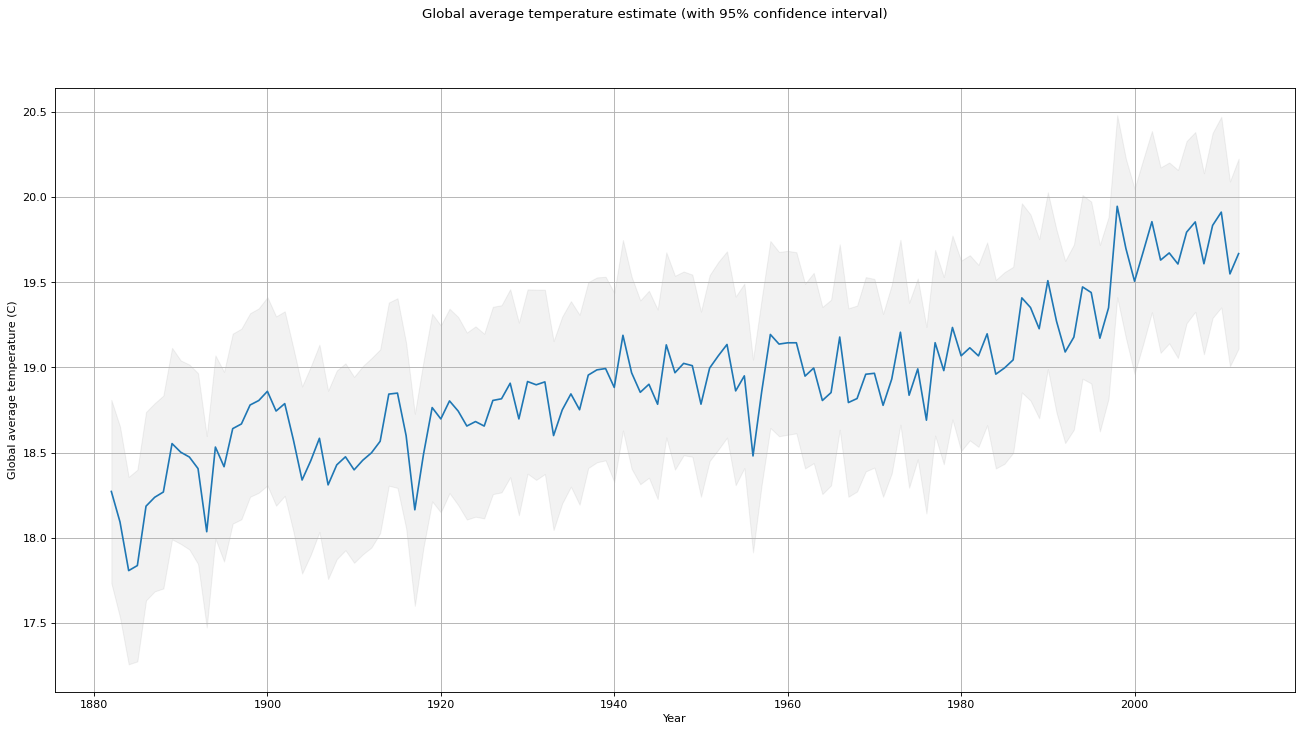

In [36]:
x = df12['date']
y = df12['temp_avg']
fig = figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Global average temperature estimate (with 95% confidence interval)')

plt.fill_between(x, df12['ci_low'], df12['ci_high'], color = 'k',alpha = 0.05)
plt.plot(x, y)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Global average temperature (C)')